<a href="https://colab.research.google.com/github/maiam6242/Facial_Blur/blob/master/Facial_Blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drawing recognition with convolutional neural networks

Colin Snow and Maia Matterman


##### Data
We begin by importing required python modules and our datasets from google and then converting them to numpy arrays. We import four datasets, each containing one type of image. We chose to use datasets of tower, bear, airplane, broccoli, dog, and broom images. This was mostly based on which ones we thought looked good/funny, but also gives a good representation of both living and static items and both geometric and organic shapes.


In [2]:
!pip install torchviz
# !CUDA_LAUNCH_BLOCKING=1
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time
import gdown
import pandas as pd


gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy', 'eiffeltower.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy', 'bear.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy', 'airplane.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broccoli.npy', 'broccoli.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy', 'dog.npy', False)
gdown.download('https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy', 'broom.npy', False)

Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy
To: /content/eiffeltower.npy
100%|██████████| 106M/106M [00:00<00:00, 148MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bear.npy
To: /content/bear.npy
100%|██████████| 106M/106M [00:01<00:00, 73.6MB/s]
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/airplane.npy
To: /content/airplane.npy
100%|██████████| 119M/119M [00:00<00:00, 155MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broccoli.npy
To: /content/broccoli.npy
100%|██████████| 104M/104M [00:00<00:00, 154MB/s]  
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
To: /content/dog.npy
100%|██████████| 119M/119M [00:00<00:00, 126MB/s] 
Downloading...
From: https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/broom.npy
To: /content/b

'broom.npy'

In [0]:
tower = np.load('eiffeltower.npy') #type = 1
bear = np.load('bear.npy') # type = 0
airplane = np.load('airplane.npy')
broccoli = np.load('broccoli.npy')
dog = np.load('dog.npy')
broom = np.load('broom.npy')



##### Visualization

Because our data is an array of numpy arrays, we can display an image as an index of the list using PIL

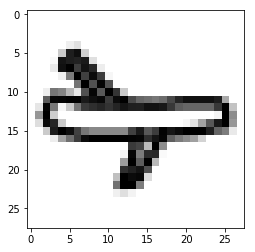

In [4]:
import matplotlib.pyplot as plt
import numpy as np

X = airplane[750]
X = np.resize(X,(28,28))
X = np.invert(X)
plt.imshow(X, cmap="gray")
plt.show()

##### Our Dataset

In addition to the google dataset, we decided to create our own data to see how changing the method of collection affected the result. We collected a full set of 6 images from 14 different people around Olin for a total of 84 new test images. We recorded the data in photoshop by giving each participant 20 seconds to draw the required image on a 28 x 28 pixel grid. We saved each of these images named by type and then imported them below to create a numpy array for each of these datasets as well.

In [5]:
from PIL import Image
import glob

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])


airplane_list = []
for filename in glob.glob('airplane*.jpg'):
    im=Image.open(filename).resize((28,28))
    airplane_list.append( np.array((np.invert(np.array(im)))))

broom_list = []
for filename in glob.glob('broom*.jpg'):
    im=Image.open(filename).resize((28,28))
    broom_list.append( np.array((np.invert(np.array(im)))))

bear_list = []
for filename in glob.glob('bear*.jpg'):
    im=Image.open(filename).resize((28,28))
    bear_list.append( np.array((np.invert(np.array(im)))))

broccoli_list = []
for filename in glob.glob('broccoli*.jpg'):
    im=Image.open(filename).resize((28,28))
    broccoli_list.append( np.array((np.invert(np.array(im)))))

tower_list = []
for filename in glob.glob('tower*.jpg'):
    im=Image.open(filename).resize((28,28))
    tower_list.append( np.array((np.invert(np.array(im)))))

dog_list = []
for filename in glob.glob('dog*.jpg'):
    im=Image.open(filename).resize((28,28))
    dog_list.append( np.array((np.invert(np.array(im)))))

dog_list = np.array(dog_list)
broccoli_list = np.array(broccoli_list)
bear_list = np.array(bear_list)
broom_list = np.array(broom_list)
airplane_list = np.array(airplane_list)
print(len(tower_list))
tower_list = np.array(tower_list)


# dog_list = np.reshape(dog_list, (14,1024))

# plt.imshow(dog_list[6],cmap="gray")
# print(np.array(airplane_list[0]))
# print(len(np.array(dog_list)))
print(np.shape(np.array(airplane_list[0])))
# print(dog_list[6])

14
(28, 28)


In [6]:
from torch.utils.data import Dataset
from torch.utils.data import random_split

import torch

class QuickDrawData(Dataset):
    def __init__(self, *args):
        super(QuickDrawData, self).__init__()
        count = 0
        # self.data = np.empty(args[0].shape, dtype=int)
        # self.targets = np.empty(args[0].shape, dtype=int)
        self.classes = []
        for arg in args:
          # print(str(arg))
          if type(arg) == str:
            self.classes += arg
          else:

            if count == 0:
              print(arg.shape)
              self.data = np.array(arg)
              self.targets = np.array(0*np.ones(arg.shape[0], dtype = int))
              print(self.targets)
              print(type(self.targets))
              print(type(self.data))
              print(type(self.classes))
            else:
              self.data = np.vstack((self.data, arg))
              print(int(count)*np.ones(arg.shape[0], dtype = int))
              print(self.targets)
              self.targets = np.hstack((self.targets, int(count)*np.ones(arg.shape[0], dtype = int)))
            count+=1
    
    def __len__(self):
        return self.targets.shape[0]
    
    def __getitem__(self, index):
        # print(self.data[index, :])
        # print(type(self.data[index, :]))
        # print(np.size(self.data[index, :]))
        return torch.FloatTensor(self.data[index, :].reshape((28, 28))).unsqueeze(0), int(self.targets[index])

quick_draw_data = QuickDrawData(tower, bear, airplane, broccoli, dog, broom, 'tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')

testdata = QuickDrawData(np.array(tower_list), np.array(bear_list), np.array(airplane_list), np.array(broccoli_list), np.array(dog_list), np.array(broom_list), 'tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')

(134801, 784)
[0 0 0 ... 0 0 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]
[2 2 2 ... 2 2 2]
[0 0 0 ... 1 1 1]
[3 3 3 ... 3 3 3]
[0 0 0 ... 2 2 2]
[4 4 4 ... 4 4 4]
[0 0 0 ... 3 3 3]
[5 5 5 ... 5 5 5]
[0 0 0 ... 4 4 4]
<class 'numpy.ndarray'>
(14, 28, 28)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [0]:
x = int(len(quick_draw_data)*.9) 
train, test = random_split(quick_draw_data, [x,(len(quick_draw_data) - x)])


In [0]:
# Data set information

image_dims = 1, 28, 28
n_training_samples = len(train) # How many training images to use
# n_test_samples = len(test) # How many test images to use
n_test_samples = 84 # How many test images to use                       --------------
classes = ('tower', 'bear', 'airplane', 'brocolli', 'dog', 'broom')

# Load the training set
train_set = train
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Load the test set

# choose correct set                                                    ---------------

test_set = test
test_set2 = testdata

# test_set = torch.cat([test, testdata],1)
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [10]:
type(test_set)

torch.utils.data.dataset.Subset

In [0]:
class MyCNN(nn.Module):
  
  def __init__(self):
    super(MyCNN, self).__init__()
    
    num_kernels = 16

    fcl_size = 256
    fcl_size2 = 128
    fcl_size3 = 64

    
    self.conv1 = nn.Conv2d(1, num_kernels, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.conv2 = nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    self.maxpool_output_size1 = int(num_kernels*(image_dims[1]/2) * (image_dims[2]/2))
    self.maxpool_output_size2 = int(num_kernels*(image_dims[1]/4) * (image_dims[2]/4)*2)

    self.batchnorm1 = nn.BatchNorm2d(num_kernels)
    self.batchnorm2 = nn.BatchNorm2d(num_kernels*2)
    self.batchnorm3 = nn.BatchNorm1d(fcl_size)
    self.batchnorm4 = nn.BatchNorm1d(fcl_size2)
    self.batchnorm5 = nn.BatchNorm1d(fcl_size3)


    self.fc1 = nn.Linear(1568, fcl_size)
    self.activation_func = torch.nn.ReLU()
    # fc2_size = fcl_size

    self.fc2 = nn.Linear(fcl_size, fcl_size2)
    self.fc4 = nn.Linear(fcl_size2, fcl_size3)
    # self.fc7 = nn.Linear(fcl_size, fcl_size)

    self.activation_func = torch.nn.ReLU()

    fc3_size = len(classes)
    # fc3_size = 6
    self.fc3 = nn.Linear(fcl_size3, fc3_size)
    
  def forward(self, x):
    x = self.conv1(x)

    x = self.activation_func(x)

    x = self.batchnorm1(x)

    x = self.pool1(x)

    x = self.conv2(x)

    x = self.activation_func(x)

    x = self.batchnorm2(x)

    x = self.pool2(x)

    # x = self.pool1(x)
    # x = self.activation_func(x)
    # x = x.view(-1, self.maxpool_output_size1)
    # x = self.pool2(x)
    # x = self.activation_func(x)
    x = self.activation_func(x)
    x = x.view(-1, self.maxpool_output_size2)

    # print(x.size())

    x = self.fc1(x)


    # print(x.size())

    # x = self.batchnorm3(x)

    x = self.activation_func(x)

    x = self.fc2(x)

    # x = self.batchnorm4(x)

    x = self.activation_func(x)

    x = self.fc4(x)

    # x = self.batchnorm5(x)

    x = self.activation_func(x)
    # x = self.fc2(x)
    # x = self.activation_func(x)
    x = self.fc3(x)
    x = torch.nn.functional.log_softmax(x)
    # x = self.activation_func(x)

    # x = self.activation_func7(x)
    return x

  def get_loss(self, learning_rate):
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    return loss, optimizer
  

In [0]:
net = MyCNN()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


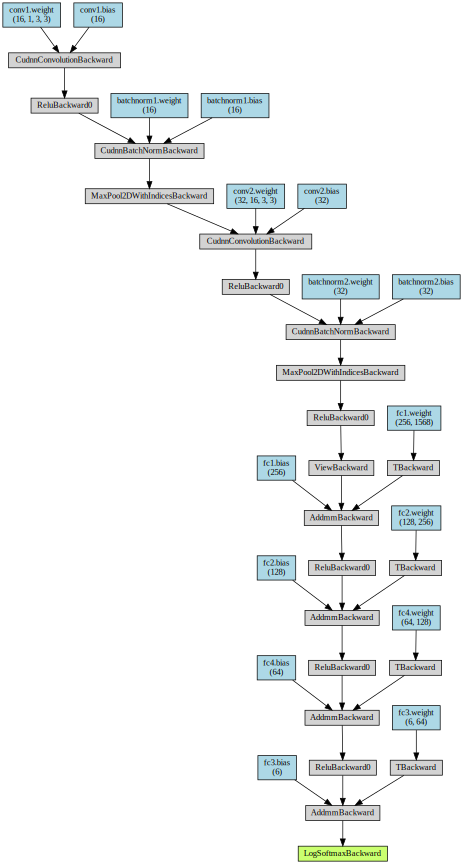

In [13]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1, image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)
# 
visualize_network(net)

In [0]:
# Define training parameters
batch_size = 32
learning_rate = 1e-2
n_epochs = 5
# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, sampler=train_sampler, num_workers = 2)
test_loader2 = torch.utils.data.DataLoader(testdata, batch_size = 84, sampler=test_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, sampler=test_sampler, num_workers = 2)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 200
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [15]:
test_set[0]

(tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,  22., 101.,  46.,  19.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,  48., 115., 168., 239., 255., 255., 252., 169.,  29.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 142., 222.,
           241., 253., 255., 255., 255., 255., 255., 255., 255., 134.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  85., 144., 247., 199.,
           136., 201., 255., 237., 204., 177., 196., 252., 242.,  40.,   0.,
             0.,   0.,   0.,   0.,   0

In [16]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1, Iteration 200	 train_loss: 0.77 took: 1.92s
Epoch 1, Iteration 400	 train_loss: 0.52 took: 1.79s
Epoch 1, Iteration 600	 train_loss: 0.45 took: 1.75s
Epoch 1, Iteration 800	 train_loss: 0.43 took: 1.79s
Epoch 1, Iteration 1000	 train_loss: 0.39 took: 1.78s
Epoch 1, Iteration 1200	 train_loss: 0.36 took: 1.77s
Epoch 1, Iteration 1400	 train_loss: 0.38 took: 1.78s
Epoch 1, Iteration 1600	 train_loss: 0.37 took: 1.79s
Epoch 1, Iteration 1800	 train_loss: 0.36 took: 1.74s
Epoch 1, Iteration 2000	 train_loss: 0.36 took: 1.73s
Epoch 1, Iteration 2200	 train_loss: 0.34 took: 1.74s
Epoch 1, Iteration 2400	 train_loss: 0.35 took: 1.76s
Epoch 1, Iteration 2600	 train_loss: 0.34 took: 1.72s
Epoch 1, Iteration 2800	 train_loss: 0.36 took: 1.76s
Epoch 1, Iteration 3000	 train_loss: 0.36 took: 1.72s
Epoch 1, Iteration 3200	 train_loss: 0.35 took: 1.71s
Epoch 1, Iteration 3400	 train_loss: 0.34 took: 1.75s
Epoch 1, Iteration 3600	 train_loss: 0.34 took: 1.73s
Epoch 1, Iteration 3800	 train_l

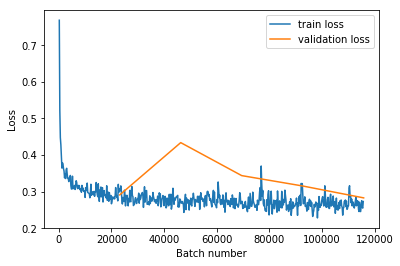

In [17]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
# plt.xlim(20000,120000)
# plt.ylim(0,.4)
plt.show()


In [18]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))
print("Test accuracy is", get_accuracy(net, test_loader2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train accuracy is 0.9228456724460979
Test accuracy is 0.9047619047619048
Test accuracy is 0.7142857142857143


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


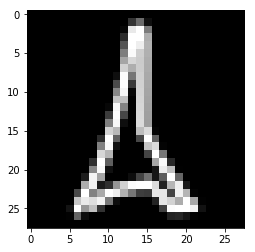

0
0
2.4063626635186095e-07
[[-2.2888184e-05 -1.2093451e+01 -2.1438517e+01 -3.0718925e+01
  -1.9910927e+01 -1.0953428e+01]]


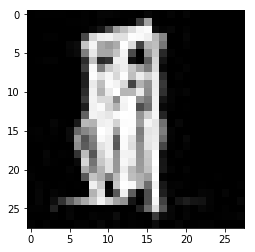

1
0
0.00805506057359772
[[-6.905057   -0.18458366 -4.942439   -3.9888139  -2.0073504  -4.886998  ]]


In [19]:
def examine_label(idx):
    image, label = test_set[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    confidence = class_scores.cpu().detach().numpy()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print(prediction)
    print(label)
    print(max(confidence[0])/sum(confidence[0]))
    print(confidence)

def examine_labelours(idx):
    image, label = test_set2[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    confidence = class_scores.cpu().detach().numpy()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print(prediction)
    print(label)
    print(max(confidence[0])/sum(confidence[0]))
    print(confidence)

examine_label(7)
examine_labelours(7)


In [20]:
gdown.download('https://l.facebook.com/l.php?u=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1K7Erwhj8naBng_RoUWnI2hJmfwzgzMKQ%3Fusp%3Dsharing%26fbclid%3DIwAR1PKsukqEVTM0NUn0KB_YmqAhgO1Sr0DnAb_xGUKSHRC4OemawFx-5gU_Q&h=AT3lp_oIwm9ztQaGRUMXdkq6oUG-Y4Gcyz1KvOqwX7WXRGPWY0qcpMlA3gHDjBsPe80nkLJo3VcTJiB-fPM4VoftAwq9P7yT5PvXs-Azjya2RsqiNJpnwKl30cL0jixwxVGLfrFryiI', 'testimages', False)

Downloading...
From: https://l.facebook.com/l.php?u=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1K7Erwhj8naBng_RoUWnI2hJmfwzgzMKQ%3Fusp%3Dsharing%26fbclid%3DIwAR1PKsukqEVTM0NUn0KB_YmqAhgO1Sr0DnAb_xGUKSHRC4OemawFx-5gU_Q&h=AT3lp_oIwm9ztQaGRUMXdkq6oUG-Y4Gcyz1KvOqwX7WXRGPWY0qcpMlA3gHDjBsPe80nkLJo3VcTJiB-fPM4VoftAwq9P7yT5PvXs-Azjya2RsqiNJpnwKl30cL0jixwxVGLfrFryiI
To: /content/testimages
82.2kB [00:00, 11.1MB/s]


'testimages'

In [0]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('*.jpg'):
    im=Image.open(filename)
    image_list.append(im)

In [22]:
print(image_list)

[<PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFBAC79668>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB3508DA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB3567320>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FD0085DFC88>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB352E828>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB3510780>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB351D8D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB3469D68>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB3469C18>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB340A128>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB340A208>, <PIL.JpegImagePlugin.JpegImageFile image mode=L size=32x32 at 0x7FCFB340A2B0>, <PIL.JpegImagePlugin.JpegImageFile image mode=L siz

In [23]:
imageArray = []
for image in image_list:
    print(np.invert(np.array(image)))
    # imageArray = np.concatenate(imageArray, np.array(image))


[[0 0 0 ... 0 0 6]
 [0 0 0 ... 3 1 2]
 [0 0 0 ... 0 2 0]
 ...
 [0 0 0 ... 0 0 6]
 [0 3 1 ... 3 0 1]
 [0 2 0 ... 2 0 1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 2 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [3 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [3 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [

√